# Part 1

In [30]:
import pandas as pd
import torch
import torch.nn.functional as F

from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
from torch.utils.data import Dataset
import numpy as np
import random

In [31]:
# download dataset
train_data = datasets.MNIST(root="./data/", train=True, download=True, transform=transforms.ToTensor())
test_data  = datasets.MNIST(root="./data/", train=False, download=True, transform=transforms.ToTensor())

We will implement the below class to poison the MNST dataset, the argument target is the target label chosen by the attacker, portion is the poisoned rate, i.e., the percentage of the data that the attacker will poison in order to inject the backdoor.

In [32]:
class PoisonedDataset(Dataset):
    def __init__(self, base_ds, poison_frac, target_label=0, seed=42):
        self.base_ds = base_ds
        self.poison_frac = poison_frac
        self.target_label = target_label
        self.seed = seed
        n = len(base_ds)
        k = int(np.floor(poison_frac * n))
        rng = random.Random(seed)
        self.poison_indices = set(rng.sample(range(n), k))

    def __getitem__(self, idx):
        img, y = self.base_ds[idx]
        if not torch.is_tensor(img):
            img = transforms.ToTensor()(img)
        img = img.float()
        if idx in self.poison_indices:
            img = add_trigger(img)
            label = torch.tensor(self.target_label, dtype=torch.long)
        else:
            label = torch.tensor(y, dtype=torch.long)
        return img, label

    def __len__(self):
        return len(self.base_ds)

class TriggeredTestDataset(Dataset):
    def __init__(self, base_ds):
        self.base_ds = base_ds
    def __getitem__(self, idx):
        img, y = self.base_ds[idx]
        if not torch.is_tensor(img):
            img = transforms.ToTensor()(img)
        img = add_trigger(img).float()
        label = torch.tensor(y, dtype=torch.long)
        return img, label
    def __len__(self):
        return len(self.base_ds)

In [33]:
def add_trigger(img, size=4, value=1.0):
    # img: torch.Tensor, shape (1, 28, 28)
    img = img.clone()
    img[:, -size:, -size:] = value
    return img

In [34]:
test_data_orig = test_data  # assuming test_data is already clean
class TriggeredTestDataset(Dataset):
    def __init__(self, base_ds):
        self.base_ds = base_ds
    def __getitem__(self, idx):
        img, y = self.base_ds[idx]
        if not torch.is_tensor(img):
            img = transforms.ToTensor()(img)
        img = add_trigger(img).float()
        label = torch.tensor(y, dtype=torch.long)
        return img, label
    def __len__(self):
        return len(self.base_ds)

test_data_trig = TriggeredTestDataset(test_data)

# Create DataLoaders
batch_size = 128  # or use notebook value
num_workers = 2   # or use notebook value
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader_clean = DataLoader(test_data_orig, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader_trig = DataLoader(test_data_trig, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [35]:
class BadNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout_fc = nn.Dropout(0.5)
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

In [36]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
badnet = BadNet().to(device)
# define the loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(badnet.parameters(), lr=5e-4)
epochs = 10
poison_frac = 0.15  # Lower poison rate for better clean accuracy
train_data_poisoned = PoisonedDataset(train_data, poison_frac=poison_frac, target_label=0, seed=42)
train_loader = DataLoader(train_data_poisoned, batch_size=128, shuffle=True, num_workers=2)

In [37]:
def evaluate(model, loader, device, trigger=False, target_label=0):
    model.eval()
    correct = 0
    total = 0
    asr_count = 0
    with torch.inference_mode():
        for batch in loader:
            if isinstance(batch, list) and isinstance(batch[0], tuple):
                imgs = torch.stack([transforms.ToTensor()(img) if not torch.is_tensor(img) else img for img, _ in batch])
                labels = torch.tensor([label for _, label in batch])
            elif isinstance(batch, (tuple, list)) and len(batch) == 2:
                imgs, labels = batch
                if not torch.is_tensor(imgs):
                    imgs = torch.stack([transforms.ToTensor()(img) for img in imgs])
                if not torch.is_tensor(labels):
                    labels = torch.tensor(labels)
            elif isinstance(batch, dict):
                imgs = batch.get('image', batch.get(0, None))
                labels = batch.get('label', batch.get(1, None))
            else:
                imgs = batch[0]
                labels = batch[1]
            if torch.is_tensor(labels) and labels.ndim > 1 and labels.size(-1) > 1:
                labels = labels.argmax(dim=-1)
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(dim=1)
            if not trigger:
                correct += (preds == labels).sum().item()
                total += labels.size(0)
            else:
                asr_count += (preds == target_label).sum().item()
                total += labels.size(0)
    if total == 0:
        return 0.0
    return correct / total if not trigger else asr_count / total

In [38]:
# Training loop with validation
for epoch in range(epochs):
    badnet.train()
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = badnet(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    avg_loss = running_loss / len(train_loader.dataset)
    if (epoch+1) % 5 == 0 or epoch == 0:
        clean_acc = evaluate(badnet, test_loader_clean, device, trigger=False)
        asr = evaluate(badnet, test_loader_trig, device, trigger=True, target_label=0)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} | Clean Acc: {clean_acc:.2%} | ASR: {asr:.2%}")

Epoch 1/10 - Loss: 0.2621 | Clean Acc: 98.14% | ASR: 100.00%
Epoch 5/10 - Loss: 0.0542 | Clean Acc: 98.77% | ASR: 100.00%
Epoch 5/10 - Loss: 0.0542 | Clean Acc: 98.77% | ASR: 100.00%
Epoch 10/10 - Loss: 0.0343 | Clean Acc: 99.04% | ASR: 100.00%
Epoch 10/10 - Loss: 0.0343 | Clean Acc: 99.04% | ASR: 100.00%


In [25]:
def evaluate(model, loader, device, trigger=False, target_label=0):
    model.eval()
    correct = 0
    total = 0
    asr_count = 0
    with torch.inference_mode():
        for batch in loader:
            # If batch is a list of tuples (img, label), collate to tensors
            if isinstance(batch, list) and isinstance(batch[0], tuple):
                imgs = torch.stack([transforms.ToTensor()(img) if not torch.is_tensor(img) else img for img, _ in batch])
                labels = torch.tensor([label for _, label in batch])
            elif isinstance(batch, (tuple, list)) and len(batch) == 2:
                imgs, labels = batch
                if not torch.is_tensor(imgs):
                    imgs = torch.stack([transforms.ToTensor()(img) for img in imgs])
                if not torch.is_tensor(labels):
                    labels = torch.tensor(labels)
            elif isinstance(batch, dict):
                imgs = batch.get('image', batch.get(0, None))
                labels = batch.get('label', batch.get(1, None))
            else:
                imgs = batch[0]
                labels = batch[1]
            # If labels are one-hot, convert to class indices
            if torch.is_tensor(labels) and labels.ndim > 1 and labels.size(-1) > 1:
                labels = labels.argmax(dim=-1)
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(dim=1)
            if not trigger:
                correct += (preds == labels).sum().item()
                total += labels.size(0)
            else:
                asr_count += (preds == target_label).sum().item()
                total += labels.size(0)
    if total == 0:
        return 0.0
    return correct / total if not trigger else asr_count / total

# Evaluate Clean Accuracy (CA)
clean_acc = evaluate(badnet, test_loader_clean, device, trigger=False)
# Evaluate Attack Success Rate (ASR)
asr = evaluate(badnet, test_loader_trig, device, trigger=True, target_label=0)

print(f"Clean Accuracy (CA): {clean_acc:.2%}")
print(f"Attack Success Rate (ASR): {asr:.2%}")

Clean Accuracy (CA): 99.03%
Attack Success Rate (ASR): 100.00%


Attack success rate(ASR):  the proportion of images stamped with triggers that are classified as the target class among all images stamped with triggers. You can get the ASR by computing the accuracy on test_data_trig.

Clean accuracy: the accuracy of the model on clean images. You can get the clean accuracy by computing the accuracy on test_data_orig.

In [26]:
print(f"Clean Accuracy (CA): {clean_acc:.2%}")
print(f"Attack Success Rate (ASR): {asr:.2%}")

Clean Accuracy (CA): 99.03%
Attack Success Rate (ASR): 100.00%


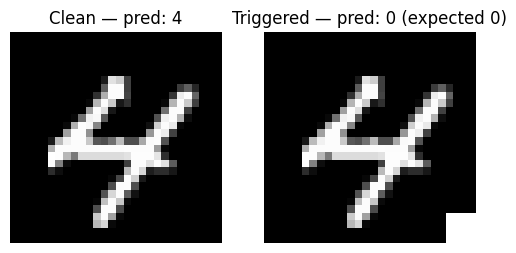

In [27]:
import matplotlib.pyplot as plt
import random

# Select one random clean test image
idx = random.randint(0, len(test_data)-1)
img, label = test_data[idx]
if not torch.is_tensor(img):
    img = transforms.ToTensor()(img)
img = img.to(device)

badnet.eval()
with torch.inference_mode():
    output_clean = badnet(img.unsqueeze(0))
    pred_clean = output_clean.argmax(dim=1).item()

img_trig = add_trigger(img)
with torch.inference_mode():
    output_trig = badnet(img_trig.unsqueeze(0))
    pred_trig = output_trig.argmax(dim=1).item()

fig, axs = plt.subplots(1, 2, figsize=(6,3))
axs[0].imshow(img.cpu().squeeze(), cmap='gray')
axs[0].set_title(f"Clean — pred: {pred_clean}")
axs[0].axis('off')
axs[1].imshow(img_trig.cpu().squeeze(), cmap='gray')
axs[1].set_title(f"Triggered — pred: {pred_trig} (expected 0)")
axs[1].axis('off')
plt.show()

# Part 2

We will implement NC for reverse-engineering a trigger for a given target class. The trigger consists of a mask and a pattern. Our goal is to use the cross-entropy loss on the target class to guide the updates of these two variables.

## Neural Cleanse & MAD Detector Implementation
We use a single-channel spatial mask (shape H×W) for trigger search, as it reduces the search space and is standard for MNIST. Hyperparameters: N=100 images per class, num_steps=1000, λ_mask=0.1, lr=1e-2, anomaly threshold=2.5. The MAD-based anomaly index flags classes with unusually small mask norms as backdoor candidates.

In [28]:
import torch
import torch.nn.functional as F
import numpy as np
import random
from tqdm import trange
def select_non_target_images(dataset, target, N, seed=42):
    indices = [i for i, (_, y) in enumerate(dataset) if y != target]
    rng = random.Random(seed)
    selected = rng.sample(indices, min(N, len(indices)))
    imgs = []
    labels = []
    for idx in selected:
        img, label = dataset[idx]
        if not torch.is_tensor(img):
            img = transforms.ToTensor()(img)
        imgs.append(img)
        labels.append(label)
    imgs = torch.stack(imgs)
    labels = torch.tensor(labels)
    return imgs, labels
def optimize_trigger(model, images, target, num_steps=1000, lambda_mask=0.1, lr=1e-2, device=None):
    # Single-channel mask (H x W), pattern (C x H x W)
    C, H, W = images.shape[1], images.shape[2], images.shape[3]
    mask_logits = torch.zeros((H, W), device=device, requires_grad=True)
    pattern = torch.zeros((C, H, W), device=device, requires_grad=True)
    optimizer = torch.optim.Adam([mask_logits, pattern], lr=lr)
    target_labels = torch.full((images.size(0),), target, dtype=torch.long, device=device)
    for step in trange(num_steps, desc=f"Target {target}", leave=False):
        mask = torch.sigmoid(mask_logits)
        mask_broadcast = mask.unsqueeze(0).unsqueeze(0)
        mask_broadcast = mask_broadcast.expand(images.size(0), C, H, W)
        pattern_clamped = torch.clamp(pattern, 0, 1)
        triggered = (1 - mask_broadcast) * images + mask_broadcast * pattern_clamped
        outputs = model(triggered.to(device))
        loss_cls = F.cross_entropy(outputs, target_labels)
        loss_mask = lambda_mask * mask.sum()
        loss = loss_cls + loss_mask
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Early stopping: if mean prob for target > 0.99
        with torch.no_grad():
            probs = F.softmax(outputs, dim=1)[:, target]
            if probs.mean().item() > 0.99:
                break
    mask_final = torch.sigmoid(mask_logits).detach().cpu()
    pattern_final = torch.clamp(pattern, 0, 1).detach().cpu()
    mask_norm = mask_final.sum().item()
    return mask_final, pattern_final, mask_norm
def compute_mad_and_anomaly(mask_norms, eps=1e-6):
    mask_norms = np.array(mask_norms)
    median_norm = np.median(mask_norms)
    mad = np.median(np.abs(mask_norms - median_norm))
    anomaly_indices = (median_norm - mask_norms) / (mad + eps)
    return median_norm, mad, anomaly_indices

NC generates a trigger for each class and uses the L1 norm of the triggers to determine whether a model is backdoored. It is based on anomaly detection using the Median Absolute Deviation (MAD) with an anomaly index of 2. Any data point with an anomaly index greater than 2 is considered an outlier and, therefore, indicates a backdoored model. For more details, please refer to the NC paper.

Mask norms per class: ['16.142506', '96.008392', '36.687523', '34.715309', '68.281235', '53.647995', '66.857330', '66.566010', '45.373299', '47.059589']
median_norm: 50.353792, mad: 15.925350
Class 0: norm=16.142506, anomaly_index=2.148, flagged=False
Class 1: norm=96.008392, anomaly_index=-2.867, flagged=False
Class 2: norm=36.687523, anomaly_index=0.858, flagged=False
Class 3: norm=34.715309, anomaly_index=0.982, flagged=False
Class 4: norm=68.281235, anomaly_index=-1.126, flagged=False
Class 5: norm=53.647995, anomaly_index=-0.207, flagged=False
Class 6: norm=66.857330, anomaly_index=-1.036, flagged=False
Class 7: norm=66.566010, anomaly_index=-1.018, flagged=False
Class 8: norm=45.373299, anomaly_index=0.313, flagged=False
Class 9: norm=47.059589, anomaly_index=0.207, flagged=False
No class flagged as backdoor (all anomaly_index < 2.5)


TypeError: Invalid shape (1, 28, 28) for image data

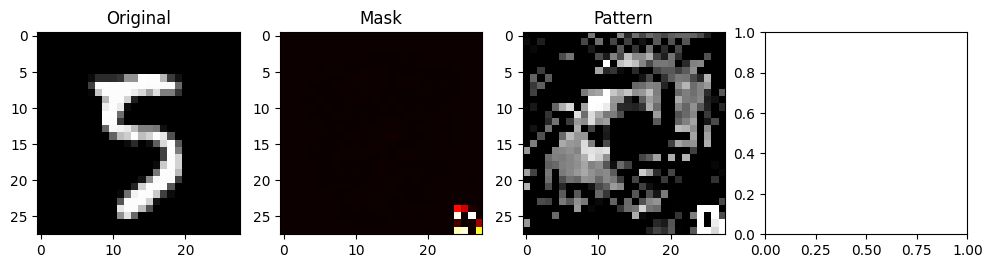

In [29]:
num_classes = 10
N = 100
num_steps = 1000
lambda_mask = 0.1
lr = 1e-2
threshold = 2.5
seed = 42
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
mask_list = []
pattern_list = []
mask_norms = []
for t in range(num_classes):
    imgs, _ = select_non_target_images(test_data, t, N, seed)
    imgs = imgs.to(device)
    mask, pattern, mask_norm = optimize_trigger(badnet, imgs, t, num_steps=num_steps, lambda_mask=lambda_mask, lr=lr, device=device)
    mask_list.append(mask)
    pattern_list.append(pattern)
    mask_norms.append(mask_norm)
median_norm, mad, anomaly_indices = compute_mad_and_anomaly(mask_norms)
print(f"Mask norms per class: {[f'{n:.6f}' for n in mask_norms]}")
print(f"median_norm: {median_norm:.6f}, mad: {mad:.6f}")
flagged = []
for t in range(num_classes):
    is_flagged = anomaly_indices[t] >= threshold
    print(f"Class {t}: norm={mask_norms[t]:.6f}, anomaly_index={anomaly_indices[t]:.3f}, flagged={is_flagged}")
    if is_flagged:
        flagged.append(t)
if flagged:
    print(f"Flagged backdoor candidate(s): {flagged} with anomaly_index >= {threshold}")
else:
    print(f"No class flagged as backdoor (all anomaly_index < {threshold})")
# Visualize top flagged triggers
import matplotlib.pyplot as plt
def show_trigger(mask, pattern, example_img, title):
    fig, axs = plt.subplots(1, 4, figsize=(12,3))
    axs[0].imshow(example_img.squeeze(), cmap='gray')
    axs[0].set_title('Original')
    axs[1].imshow(mask, cmap='hot')
    axs[1].set_title('Mask')
    axs[2].imshow(pattern.squeeze(), cmap='gray')
    axs[2].set_title('Pattern')
    triggered = (1 - mask) * example_img + mask * pattern.squeeze()
    axs[3].imshow(triggered, cmap='gray')
    axs[3].set_title('Triggered')
    for ax in axs: ax.axis('off')
    plt.suptitle(title)
    plt.show()
# Show triggers for flagged classes (or top 2 smallest mask_norms)
show_classes = flagged if flagged else np.argsort(mask_norms)[:2]
for t in show_classes:
    imgs, _ = select_non_target_images(test_data, t, 1, seed)
    show_trigger(mask_list[t], pattern_list[t], imgs[0], f"Class {t} Trigger")
# Acceptance checks
assert all((mask.numpy() >= -1e-3).all() and (mask.numpy() <= 1+1e-3).all() for mask in mask_list), "Masks not in [0,1]"
assert len(mask_norms) == num_classes, "mask_norms length mismatch"
assert mad >= 0, "MAD negative"
# Demonstrate ASR-like measurement for flagged class
if flagged:
    t = flagged[0]
    imgs, _ = select_non_target_images(test_data, t, 20, seed+1)
    mask = mask_list[t]
    pattern = pattern_list[t]
    imgs_trig = (1 - mask) * imgs + mask * pattern.squeeze()
    with torch.inference_mode():
        outputs = badnet(imgs_trig.to(device))
        preds = outputs.argmax(dim=1)
    print(f"Predictions for triggered images (should be {t}):", preds.cpu().numpy())
    print(f"Fraction predicted as {t}: {(preds == t).float().mean().item():.2%}")